<a href="https://colab.research.google.com/github/staerkjoe/QuantRisk_Colab/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Link to dataset: https://www.kaggle.com/datasets/pkdarabi/classification-of-travel-purpose

In [4]:
import tensorflow as tf
import tf_keras as keras
import pandas as pd
# note: tensorflow 2.17 onwards uses tf.keras 3.0 internally,
# which seem to be still bugged and inconsistent.
# We therefore use tf_keras in according to tensorflow version.

import numpy as np
import os
import time

In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/QantRisk'
df = pd.read_csv(os.path.join(path, "cleaned_data_new.csv"))

In [6]:
df.head()

,ReserveStatus,Male,Price,CouponDiscount,From,To,Domestic,VIPStatus,TripReason,Vehicle,Cancel,LeadTime,IsWeekend,DiscountRatio,BookingMonth,DepartureMonth,BookingWeekday,DepartureWeekday,DepartureHour,BookingHour
0,3,0,40.54,0.0,shyrz,hwz,1,True,Work,Bus,0,63272.750,0,0.0,9,9,1,2,11,17
1,3,1,50.27,0.0,thrn,shyrz,1,True,Work,Bus,0,7215.157,0,0.0,7,7,3,3,16,13
2,3,1,24.73,0.0,thrn,Sfhn,1,True,Work,Bus,0,57761.133,0,0.0,10,10,6,0,2,9
3,3,1,26.35,0.0,thrn,tbryz,1,True,Int,Bus,0,312199.797,0,0.0,3,3,3,0,13,22
4,2,1,23.48,0.0,yzd,thrn,1,Unknown,Int,Train,0,1471280.147,0,0.0,9,9,1,4,20,20


In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression



numeric_cols = [
    'Price','CouponDiscount','DiscountRatio',
    #'FromFreq','ToFreq',
    'LeadTime',
    'IsWeekend','BookingWeekday','DepartureWeekday',
    'DepartureHour','BookingHour','BookingMonth','DepartureMonth'
]
categorical_cols = ['TripReason', 'VIPStatus','Vehicle','From', 'To' ]


preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='Cancel')  # Features
y = df['Cancel']               # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

In [10]:
logreg = XGBClassifier(
    tree_method="hist",        # Fast histogram-based method
    predictor="gpu_predictor", # Use GPU for prediction
    device="cuda",             # Target GPU device
    C = 0.01,
    penalty='l1',         # or 'l1', 'elasticnet', 'none'
    solver='liblinear',   # good for small datasets and 'l1' penalty
    max_iter=10000,        # increase if convergence warnings appear
    #class_weight='balanced',  # handles class imbalance automatically
    random_state=42       # ensures reproducibility
)

In [11]:
pipeline_logreg = Pipeline([
    ('preprocessing', preprocess),
    ('smote', smote),
    ('model', logreg)
])

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1','l2'],
    'model__solver': ['liblinear'],
}

# GridSearchCV setup
grid_search_logreg = GridSearchCV(
    pipeline_logreg,
    param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='f1',  # or use another metric
    n_jobs=-1            # use all available cores
)

In [13]:
pipeline_logreg.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# Evaluate
y_pred = pipeline_logreg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:03:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "C", "max_iter", "penalty", "predictor", "solver" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8332425661692626
F1: 0.24840451644575356
[[7397  262]
 [1269  253]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      7659
           1       0.49      0.17      0.25      1522

    accuracy                           0.83      9181
   macro avg       0.67      0.57      0.58      9181
weighted avg       0.79      0.83      0.80      9181



/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [14:03:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [14]:
'''
# Fit grid search on your data
grid_search_logreg.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)
print("Test F1:", grid_search.score(X_test, y_test))
'''

'\n# Fit grid search on your data\ngrid_search_logreg.fit(X_train, y_train)\n\nprint("Best params:", grid_search.best_params_)\nprint("Best CV score:", grid_search.best_score_)\nprint("Test F1:", grid_search.score(X_test, y_test))\n'

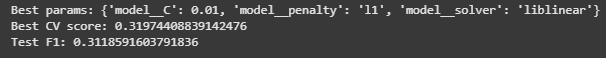

### XG Boost

In [18]:
from xgboost import XGBClassifier as xgb
xgb = xgb(
    # --- Core settings ---
    objective="binary:logistic",   # Binary classification
    eval_metric="logloss",         # Could also use 'auc', 'aucpr', or 'f1'
    random_state=42,
    use_label_encoder=False,

    # --- Model complexity ---
    n_estimators=300,              # Number of boosting rounds (trees)
    max_depth=6,                   # Max tree depth
    min_child_weight=1,            # Minimum sum of instance weight in a leaf

    # --- Learning & sampling ---
    learning_rate=0.1,             # Step size shrinkage

    # --- Regularization ---
    gamma=0,                        # Minimum loss reduction for a split
    reg_alpha=0.0,                  # L1 regularization
    reg_lambda=1.0,                 # L2 regularization

    # --- Class imbalance ---
    #scale_pos_weight=1.0,           # Set to (neg/pos) ratio in training set

    # --- Performance ---
    n_jobs=-1,                      # Use all CPU cores
    tree_method="hist", device="cuda",            # Fast, memory-efficient
    predictor="gpu_predictor"   # GPU inference
)



pipeline_xgb = Pipeline([
    ('preprocessing', preprocess),
    ('smote', smote),
    ('model', xgb)
])

In [20]:
# Now you can call the function from the library
gpu_available = xgb.core._has_cuda_support()
print("GPU available for XGBoost:", gpu_available)

AttributeError: 'XGBClassifier' object has no attribute 'core'

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define parameter grid for the most impactful XGB params
param_grid_xgb = {
    'model__n_estimators': [200, 300, 500],       # Number of trees
    'model__max_depth': [4, 6, 8],                # Tree depth
    'model__learning_rate': [0.01, 0.1, 0.3],     # Step size
    'model__min_child_weight': [1, 3, 5],         # Min weight per leaf
    'model__gamma': [0, 0.1, 0.3],                # Min loss reduction for split
    #'model__scale_pos_weight': [1, 5]             # Class imbalance handling
}

# GridSearchCV setup
grid_search_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid=param_grid_xgb,
    cv=5,                  # 5-fold cross-validation
    scoring='f1',      # Focus on F1 for cancellations
    n_jobs=-1,             # Use all CPU cores for preprocessing/SMOTE
    verbose=2
)


param_dist_xgb = {
    'model__n_estimators': randint(200, 500),
    'model__max_depth': randint(3, 8),
    'model__learning_rate': uniform(0.01, 0.3),
    'model__min_child_weight': randint(1, 6),
    'model__gamma': uniform(0, 0.5),
    'model__subsample': uniform(0.7, 0.3),
    'model__colsample_bytree': uniform(0.7, 0.3),
    'model__scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
}


random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_dist_xgb,
    n_iter=30,                     # Try 30 random combos
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
booster = grid_search_xgb.best_estimator_.get_booster()
print("Using GPU:", booster.attributes().get("predictor"))
grid_search_xgb.fit(X_train, y_train)

print("Best params:", grid_search_xgb.best_params_)
print("Best CV score:", grid_search_xgb.best_score_)
print("Test F1:", grid_search_xgb.score(X_test, y_test))

y_pred = grid_search_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
import joblib

# Extract the best fitted pipeline (preprocessing + SMOTE + XGB)
best_xgb_pipeline = grid_search_xgb.best_estimator_

# Save to file
joblib.dump(best_xgb_pipeline, "best_xgb_pipeline.pkl")
print("Model saved to best_xgb_pipeline.pkl")